In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class PINN(nn.Module):
    """Physics Informed Neural Network for solving ODES

    Attributes:
        model (nn.Sequential): The neural network model
    """

    def __init__(self, depth, width, activation):
        """Initializes the PINN model

        Args:
            depth (int): Number of hidden layers in the network
            width (int): Number of neurons in each hidder layer
        """
        super(PINN, self).__init__()

        layers = [nn.Linear(1, width), activation()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), activation()]
        layers += [nn.Linear(width, 1)]

        self.model = nn.Sequential(*layers)

    def forward(self, t):
        """Forward pass of the network

        Args:
            t (torch.Tensor): Input tensor representing time

        Returns:
            torch.Tensor: Output tensor representing the predicted solution u(t)
        """
        return self.model(t)


def pinn_loss(model, t_collocation):
    """Computes the PINN loss for the ODE

    Args:
        model (PINN): The PINN model
        t_collocation (torch.Tensor): Collocation points for training

    Returns:
        torch.Tensor: The mean squared error of the ODE residuals
    """
    t_collocation.requires_grad = True

    u = model(t_collocation)
    du_t = torch.autograd.grad(u, t_collocation, grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]

    ode_loss = du_t + 2 * u  # u'(t) + 2u(t) = 0

    return torch.mean(ode_loss ** 2)


def boundary_loss(model):
    """Computes the boundary condition loss.

    Args:
        model (PINN): The PINN model.

    Returns:
        torch.Tensor: The squared error of the boundary condition residual
    """
    t_boundary = torch.tensor([[0.0]], dtype=torch.float32)
    u_boundary = model(t_boundary)

    return (u_boundary - 3.0) ** 2  # u(0) = 3


def total_loss(model, t_collocation):
    """Computes the total loss for training the PINN

    Args:
        model (PINN): The PINN model
        t_collocation (torch.Tensor): Collocation points for training

    Returns:
        torch.Tensor: The sum of ODE and boundary condition losses
    """
    return pinn_loss(model, t_collocation) + boundary_loss(model)


def train_pinn(model, epochs, optimizer_class=optim.SGD, optimizer_params=None):
    """Trains the PINN model.

    Args:
        model (PINN): The PINN model to be trained
        optimizer_class (torch.optim.Optimizer): The optimizer class to use
        optimizer_params (dict): Parameters for the optimizer
        epochs (int): Number of training epochs

    Returns:
        PINN: The trained PINN model after training
    """

    # This can be more customizable in the future
    if optimizer_params is None:
        optimizer_params = {"lr": 1e-3}

    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    t_collocation = torch.linspace(0, 2, 100, dtype=torch.float32).unsqueeze(1)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = total_loss(model, t_collocation)
        loss.backward()
        optimizer.step()
        if epoch % 25 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model


Epoch 0, Loss: 8.613941192626953
Epoch 25, Loss: 2.88147234916687
Epoch 50, Loss: 1.0976717472076416
Epoch 75, Loss: 0.08195599913597107


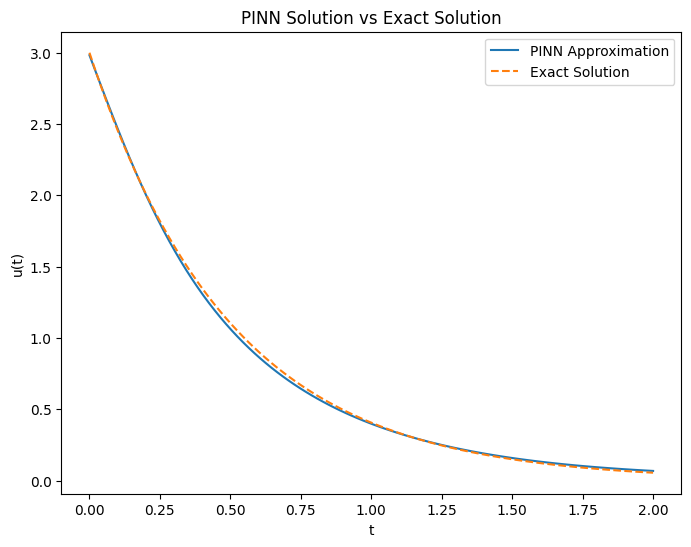

In [ ]:
model= PINN(depth=3, width=50, activation=nn.Tanh)

model = train_pinn(model, optimizer_class=optim.Adam, epochs=100)

t_test = torch.linspace(0, 2, 100, dtype=torch.float32).unsqueeze(1)
u_pred = model(t_test).detach().numpy()
u_exact = 3 * np.exp(-2 * t_test.numpy())

plt.figure(figsize=(8, 6))
plt.plot(t_test, u_pred, label="PINN Approximation")
plt.plot(t_test, u_exact, label="Exact Solution", linestyle="dashed")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.legend()
plt.title("PINN Solution vs Exact Solution")
plt.show()